In [28]:
import mediapipe as mp
import numpy as np
import cv2
import os
import json
import itertools

from glob import glob

def get_train_test_data(data_dir):
    wake_video_dir = os.path.join(data_dir, "wake/video") 
    wake_label_dir = os.path.join(data_dir, "wake/label")

    sleep_video_dir = os.path.join(data_dir, "sleep/video") 
    sleep_label_dir = os.path.join(data_dir, "sleep/label")

    wake_vido_dir_list = glob(wake_video_dir + "/*.mp4")
    wake_label_dir_list = glob(wake_label_dir + "/*.json")

    sleep_video_dir_list = glob(sleep_video_dir + "/*.mp4")
    sleep_label_dir_list = glob(sleep_label_dir + "/*.json")

    return wake_vido_dir_list, wake_label_dir_list, sleep_video_dir_list, sleep_label_dir_list


def get_dict_used_landmarks(video_dir_list, label_dir_list):
    used_dict = dict()

    use_landmark_number = np.array([11,12,23,24])

    mp_pose = mp.solutions.pose

    pose =  mp_pose.Pose(
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5)
    
    for n, video_dir in enumerate(video_dir_list):
        frame_count = 0
        label_dir = label_dir_list[n]
        all_landmarks_array = np.array([])

        with open(label_dir, "r") as f:
            label = json.load(f)
        
        label = np.array(label["is_neoti_list"])

        cap = cv2.VideoCapture(video_dir)

        fps = cap.get(cv2.CAP_PROP_FPS)
        
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            if frame_count % fps != 0:
                label = np.delete(label, 0)
                frame_count += 1
                continue

            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = pose.process(frame)

            if results.pose_landmarks:
                landmark_array = np.array([])
                for i, idx in enumerate(use_landmark_number):
                    landmark = results.pose_landmarks.landmark[idx]
                    x = landmark.x
                    y = landmark.y
                    #z = landmark.z
                    #landmark = np.array([x, y, z])
                    landmark = np.array([x, y])
                    if i == 0:
                        landmark_array = landmark
                    else:
                        landmark_array = np.hstack((landmark_array, landmark))
                #print(landmark_array.shape)
            else:
                #print("No Landmarks")
                label = np.delete(label, 0)
                continue
                
            if len(all_landmarks_array) == 0:
                all_landmarks_array = landmark_array
            else:
                all_landmarks_array = np.vstack((all_landmarks_array, landmark_array))

            frame_count += 1

        used_dict[video_dir]  = dict()
        used_dict[video_dir]["landmark"] = all_landmarks_array
        used_dict[video_dir]["label"] = label
        print(all_landmarks_array.shape)
        print(label.shape)
        
        cap.release()

    return used_dict

data_dir = "output"

wake_video_list, wake_label_list , sleep_video_list, sleep_label_list = get_train_test_data(data_dir)

wake_dict = get_dict_used_landmarks(wake_video_list, wake_label_list)
sleep_dict = get_dict_used_landmarks(sleep_video_list, sleep_label_list)



c:\Users\yuhei\anaconda3\envs\pytorch_env\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


(300, 8)
(300,)
(300, 8)
(300,)
(299, 8)
(299,)
(300, 8)
(300,)
(300, 8)
(300,)
(300, 8)
(300,)
(300, 8)
(300,)
(300, 8)
(300,)
(300, 8)
(300,)
(300, 8)
(300,)
(299, 8)
(299,)
(300, 8)
(300,)
(300, 8)
(300,)
(300, 8)
(300,)
(285, 8)
(285,)
(300, 8)
(300,)
(300, 8)
(300,)
(300, 8)
(300,)
(300, 8)
(300,)
(300, 8)
(300,)
(300, 8)
(300,)
(300, 8)
(300,)
(300, 8)
(300,)
(300, 8)
(300,)


In [30]:
from tqdm import tqdm

def get_merge_combination(wake_dict, sleep_dict):
    wake_keys_list = list(wake_dict.keys())
    sleep_keys_list = list(sleep_dict.keys())

    #listを結合
    merge_combination_list = wake_keys_list + sleep_keys_list

    return merge_combination_list

def get_stacked_data(wake_dict, sleep_dict, merge_combination_list):

    stacked_data_dict = dict()
    
    for i, key in enumerate(merge_combination_list):

        #keyがwakeの場合（動画の数は12個）
        if i < 12:
            if i == 0:
                wake_landmark = wake_dict[key]["landmark"]
                wake_label = wake_dict[key]["label"]
            else:
                wake_landmark = np.vstack((wake_landmark, wake_dict[key]["landmark"]))
                wake_label = np.hstack((wake_label, wake_dict[key]["label"]))

        #keyがsleepの場合（動画の数は12個）
        else:
            if i == 12:
                sleep_landmark = sleep_dict[key]["landmark"]
                sleep_label = sleep_dict[key]["label"]
            else:
                sleep_landmark = np.vstack((sleep_landmark, sleep_dict[key]["landmark"]))
                sleep_label = np.hstack((sleep_label, sleep_dict[key]["label"]))

    stacked_landmark = np.vstack((wake_landmark, sleep_landmark))
    stacked_label = np.hstack((wake_label, sleep_label))

    stacked_data_dict["landmark"] = stacked_landmark
    stacked_data_dict["label"] = stacked_label

    return stacked_data_dict

def get_windowed_data(stacked_data_dict, window_size=8):
    windowed_data_dict = dict()


    landmark = stacked_data_dict["landmark"]
    label = stacked_data_dict["label"]

    windowed_landmark = np.array([])
    windowed_label = np.array([])

    #slidingwindow(step=1)
    #labelは最後の値を採用

    for i in tqdm(range(0, len(landmark) - window_size + 1)):
        #次元を追加
        windowed_landmark_array = np.expand_dims(landmark[i:i+window_size], axis=0)
        windowed_label_array = np.array([label[i+window_size-1]])

        if len(windowed_landmark) == 0:
            windowed_landmark = windowed_landmark_array
            windowed_label = windowed_label_array

        else:
            windowed_landmark = np.vstack((windowed_landmark, windowed_landmark_array))
            windowed_label = np.hstack((windowed_label, windowed_label_array))

        #print(windowed_landmark.shape)
        #print(windowed_label.shape)

    windowed_data_dict = dict()
    windowed_data_dict["landmark"] = windowed_landmark
    windowed_data_dict["label"] = windowed_label

    return windowed_data_dict

merge_combination_list = get_merge_combination(wake_dict, sleep_dict)   

print("Finish Get All Combination")

stacked_data_dict = get_stacked_data(wake_dict, sleep_dict, merge_combination_list)

print("Finish Stacked Data")

windowed_data_dict = get_windowed_data(stacked_data_dict, window_size=8)

print("Finish Windowed Data")




Finish Get All Combination
Finish Stacked Data


100%|██████████| 7176/7176 [00:03<00:00, 2372.94it/s] 

Finish Windowed Data


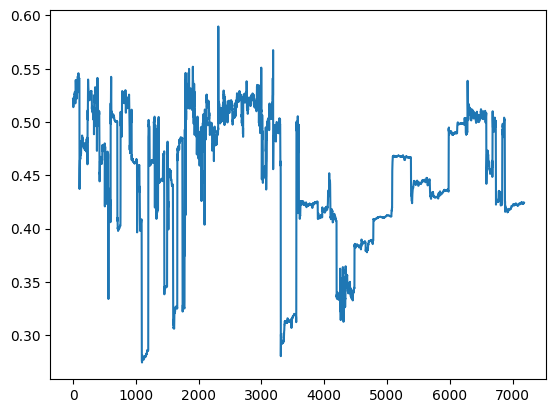

In [36]:
#landmarkを可視化
#pcaで次元削減して可視化

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

landmark = stacked_data_dict["landmark"]

#体の中心を計算
o = landmark[:, 0] #右肩
A = landmark[:, 1] #左肩
B = landmark[:, 2] #右腰
C = landmark[:, 3] #左腰

#肩の中心
shoulder_center = (o + A) / 2
#腰の中心
waist_center = (B + C) / 2

#体の中心
center = (shoulder_center + waist_center) / 2



plt.plot(range(len(landmark)), center)

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

#データセットの作成

#データの分割
landmark = windowed_data_dict["landmark"]
#landmark = pca_landmark
label = windowed_data_dict["label"]
print(landmark.shape)

landmark_train, landmark_test, label_train, label_test = train_test_split(landmark, label, test_size=0.2, random_state=42)

#データセットの作成
class MyDataset(data.Dataset):
    def __init__(self, landmark, label):
        self.landmark = landmark
        self.label = label

    def __len__(self):
        return len(self.landmark)

    def __getitem__(self, index):
        return torch.tensor(self.landmark[index]), torch.tensor(self.label[index])
    
train_dataset = MyDataset(landmark_train, label_train)
test_dataset = MyDataset(landmark_test, label_test)

train_loader = data.DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=4, shuffle=False)

#モデルの作成
#batch_first=True
#input_data = (batch_size, seq_len, input_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))

        out = self.fc(out[:, -1, :])

        return out
    
def train_test_model(model, train_loader, test_loader, input_size, hidden_size, num_layers, num_classes, num_epochs=100, lr=0.001):
    model = model(input_size, hidden_size, num_layers, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (landmark, label) in enumerate(train_loader):
            landmark = landmark.to(device).float()
            label = label.to(device).long()

            outputs = model(landmark)
            prob = F.softmax(outputs, dim=1)
            loss = criterion(prob, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print("Epoch: {}, Loss: {}".format(epoch, running_loss))

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for i, (landmark, label) in enumerate(test_loader):
            landmark = landmark.to(device).float()
            label = label.to(device).long()

            outputs = model(landmark)
            prob = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            total += label.size(0)
            correct += (predicted == label).sum().item()

        print("Accuracy: {}".format(correct / total))

    return model


(7176, 8, 8)


In [39]:
input_size = 8
hidden_size = 128
num_layers = 8
num_classes = 2

model = train_test_model(LSTM, train_loader, test_loader, input_size, hidden_size, num_layers, num_classes, num_epochs=10, lr=0.001)

Epoch: 0, Loss: 747.1960645914078
Epoch: 1, Loss: 995.7580751180649
Epoch: 2, Loss: 995.5501010417938
Epoch: 3, Loss: 994.661073744297
Epoch: 4, Loss: 995.0773351788521
Epoch: 5, Loss: 994.9080803990364
Epoch: 6, Loss: 995.3742493987083
Epoch: 7, Loss: 995.2918100953102
Epoch: 8, Loss: 995.2252514362335
Epoch: 9, Loss: 995.4497371912003
Accuracy: 0.49303621169916434
